<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-in-ENM-data" data-toc-modified-id="Read-in-ENM-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in ENM data</a></span></li><li><span><a href="#ENM-data-frames" data-toc-modified-id="ENM-data-frames-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ENM data frames</a></span></li><li><span><a href="#ENM-WF-bins" data-toc-modified-id="ENM-WF-bins-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ENM WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Similarity-heatmap" data-toc-modified-id="Similarity-heatmap-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Similarity heatmap</a></span></li><li><span><a href="#Dendrograms-and-elbow-graph" data-toc-modified-id="Dendrograms-and-elbow-graph-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Dendrograms and elbow graph</a></span></li><li><span><a href="#Helper-class-for-selecting-best-ENM-estimator" data-toc-modified-id="Helper-class-for-selecting-best-ENM-estimator-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Helper class for selecting best ENM estimator</a></span></li><li><span><a href="#Gridsearch-to-select-n_clusters" data-toc-modified-id="Gridsearch-to-select-n_clusters-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Gridsearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration" data-toc-modified-id="Apply-feature-agglomeration-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Apply feature agglomeration</a></span></li><li><span><a href="#Concatenate-final-dataframe" data-toc-modified-id="Concatenate-final-dataframe-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>Concatenate final dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Preliminary-models" data-toc-modified-id="Preliminary-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preliminary models</a></span></li></ul></div>

# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

# Set random seed across notebook for repeatable results
np.random.seed(1922)

In [19]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [20]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [21]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

## Read in ENM data

In [32]:
# Read in engineered nanomaterials (ENM) weight fraction (WF) data ("labels")
y_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", usecols=[4])

# Read in potential predictive variables ("features") for ENM WF
X_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", index_col=0)

Note that each feature either has a prefix, or will be assigned a prefix that indicates what "data group" it belongs under.
* cprp = chemical property
* func = chemical functional use
* pgen = general product category
* pgrp = product groups (a subset of a category)
* mtrx = product matrix property

After agglomeration, two new prefixes are introduced:
* fagg = aggregated chemical functional uses
* pagg = aggregated product categories

The following code cleans the data and column names.

In [33]:
# Drop unwanted columns
# For PUC, keeping gencat, group, refined, assigned ("matrix")
# Drop dehydrating_agent[22], dispersing_agent[24], fuel_agent[27]
X_enm.drop(
    X_enm.columns[[0, 1, 2, 3, 4, 9, 12, 22, 24, 27, 34, 35, 36]], axis=1, inplace=True
)

# Rename columns
X_enm.columns = X_enm.columns.str.replace("_", "")
X_enm.rename(
    columns={
        "gencatID": "pgen",
        "group": "pgrp",
        "refinedproducttype": "refined",
        "assignedID": "mtrx",
        "measured": "mtrx_WFmeasured",
        "antistainagent": "antiredepositionagent",
        "lubricatingagent": "antiadhesivecohesive",
        "uvstabilizer": "UVstabilizer",
    },
    inplace=True,
)

# To maintain atomicity, assign all child-specific products (C) as articles (A)
# and all OTC pharmaceuticals (P) as formulas (F) (they were all liquids)
X_enm["mtrx"] = X_enm["mtrx"].replace("C", "A", regex=True)
X_enm["mtrx"] = X_enm["mtrx"].replace("P", "F", regex=True)

# Clean up data in refined column so it's only spray vs NOC
X_enm.loc[X_enm.refined != "spray", "refined"] = "NOC"

# Transform factor data (product categories) into binary columns
X_enm = pd.get_dummies(
    X_enm,
    prefix=["pgen", "pgrp", "refined", "mtrx"],
    columns=["pgen", "pgrp", "refined", "mtrx"],
)

# Remove spaces from column names
X_enm.columns = X_enm.columns.str.replace(" ", "")
X_enm.columns = X_enm.columns.str.replace("/", "")
X_enm.columns = X_enm.columns.str.replace("-", "")
X_enm.columns = X_enm.columns.str.replace("and", "")

# Edit column name prefixes and suffixes for consistency and clarity
X_enm.columns = X_enm.columns.str.replace("Density", "density")
X_enm.columns = X_enm.columns.str.replace("prop", "cprp_")
X_enm.columns = X_enm.columns.str.replace("refined", "mtrx")
X_enm.columns = X_enm.columns.str.replace("mtrx_F", "mtrx_formulation")
X_enm.columns = X_enm.columns.str.replace("relatedproducts", "related")

# Drop columns absent from organics
X_enm.drop(
    [
        "pgen_AP",
        "pgen_CS",
        "pgen_FC",
        "pgen_PH",
        "mtrx_NOC",  # not otherwise categorizable
        "mtrx_A",  # duplicative of mtrx_formulation
    ],
    axis=1,
    inplace=True,
)

# Rearrange feature order
cols = X_enm.columns.tolist()
cols = cols[:5] + [cols[16]] + cols[5:16] + cols[17:]  # Move anti_adh. up
cols = cols[:20] + cols[21:] + [cols[20]]  # WF_measured to end
X_enm = X_enm[cols]

# Add 'func' prefix to functional uses
cols = X_enm.columns
idx_func = np.asarray([i for i, c in enumerate(cols) if not "_" in c])
X_enm.rename(columns={c: "_".join(("func", c)) for c in cols[idx_func]}, inplace=True)

Note that 'WFmeasured' is not actually a matrix property; it describes whether the WF was verified with lab analysis or if it was simply claimed by the manufacturer.

In [34]:
print(X_enm.columns)

Index(['cprp_MW', 'cprp_MP', 'cprp_BP', 'cprp_density', 'func_absorbent',
       'func_antiadhesivecohesive', 'func_antioxidant',
       'func_antiredepositionagent', 'func_biocide', 'func_brightener',
       'func_chemicalreactionregulator', 'func_colorant', 'func_deodorizer',
       'func_filler', 'func_flavouringnutrient', 'func_hardener',
       'func_humectant', 'func_opacifier', 'func_UVstabilizer',
       'func_viscositymodifier', 'pgen_AC', 'pgen_CP', 'pgen_EL', 'pgen_HM',
       'pgen_PC', 'pgen_PE', 'pgen_VE', 'pgrp_apparel', 'pgrp_bodyhygiene',
       'pgrp_childspecific', 'pgrp_coldrelief', 'pgrp_dentalcare',
       'pgrp_deodorant', 'pgrp_enginemaintenance', 'pgrp_fabrictreatmentdye',
       'pgrp_facialcleansingmoisturizing', 'pgrp_firstaid', 'pgrp_foodstorage',
       'pgrp_footcare', 'pgrp_fungicide', 'pgrp_generalhouseholdcleaning',
       'pgrp_generalmoisturizing', 'pgrp_largeappliances',
       'pgrp_makeuprelated', 'pgrp_nutritionalsupplements',
       'pgrp_paints

In [35]:
# Export column headings list
cols = X_enm.columns
with open("./data/column-headers.txt", "w") as filehandle:
    for listitem in cols:
        filehandle.write("%s\n" % listitem)

## ENM WF bins

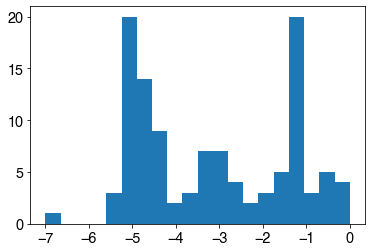

In [36]:
# Log-transformed histogram of weight fraction
fig, ax = plt.subplots()
plt.hist(np.log10(np.asarray(y_enm)), bins=20)
ax.xaxis.set_major_locator(MultipleLocator(1))

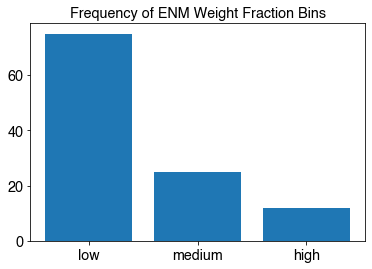

Label bin:  [0 1 2]
Count    :  [75 25 12]
Frequency:  [0.67, 0.22, 0.11]


In [37]:
# Apply bins to ENM and organics data
# (slightly different ranges from those used by Isaacs et al. 2016)
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))

# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition="ENM")

## Data summaries

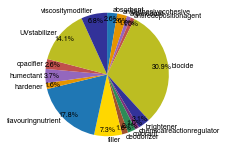

In [38]:
# ENM function breakdown as pie chart
blt.plot_piechart(
    data=X_enm,
    feat_subset_prefix="func",
    save_fig_name="a) ENM Functional Uses",
    figsize=[3, 2.5],
    labels=None,
)

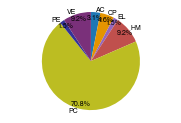

In [39]:
# ENM PUC breakdown as pie chart
blt.plot_piechart(
    data=X_enm,
    feat_subset_prefix="pgen",
    save_fig_name="c) ENM General Product Categories",
    figsize=[3, 2],
)

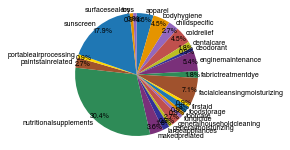

In [40]:
# ENM PUC breakdown as pie chart
blt.plot_piechart(
    data=X_enm,
    feat_subset_prefix="pgrp",
    save_fig_name="e) ENM Product Group Categories",
)

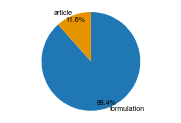

In [41]:
# ENM product matrices as pie chart
blt.plot_piechart(
    data=X_enm,
    feat_subset_prefix="mtrx_formulation",
    save_fig_name="g) ENM Product Matrix",
    figsize=[3, 2],
    labels=["formulation", "article"],
)

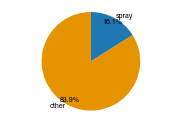

In [42]:
# ENM spray products as pie chart
blt.plot_piechart(
    data=X_enm,
    feat_subset_prefix="mtrx_spray",
    save_fig_name="i) ENM Spray Products",
    figsize=[3, 2],
)

# Export data

In [43]:
# Export ENM CP dataframe for use in modeling scripts
X_enm.to_csv(
    "./data/ENM-preprocessed-feats.csv",
    sep="\t",
    na_rep="",
    header=True,
    index=True,
    index_label=None,
    mode="w",
)